<a href="https://colab.research.google.com/github/AllenHuang03/104947567_concept2/blob/Classification-Models/Hybrid_training_models_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load datasets
df = pd.read_csv('/content/drive/My Drive/UNSW_NB15_testing-set.csv')


In [4]:
class HybridRFGB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, class_weight='balanced'):
        self.rf = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weight, random_state=42)
        self.gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
        self.calibrated_rf = None
        self.calibrated_gb = None

    def fit(self, X, y):
        self.rf.fit(X, y)
        self.gb.fit(X, y)
        self.calibrated_rf = CalibratedClassifierCV(self.rf, cv=5, method='isotonic')
        self.calibrated_gb = CalibratedClassifierCV(self.gb, cv=5, method='isotonic')
        self.calibrated_rf.fit(X, y)
        self.calibrated_gb.fit(X, y)
        return self

    def predict_proba(self, X):
        rf_pred = self.calibrated_rf.predict_proba(X)
        gb_pred = self.calibrated_gb.predict_proba(X)
        return (rf_pred + gb_pred) / 2

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def feature_importances(self):
        rf_importances = self.rf.feature_importances_
        gb_importances = self.gb.feature_importances_
        return (rf_importances + gb_importances) / 2

In [5]:
class ImprovedHybridModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, class_weight='balanced'):
        self.rf = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weight, random_state=42)
        self.gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
        self.svm = SVC(probability=True, class_weight='balanced', random_state=42)
        self.mlp = MLPClassifier(random_state=42)
        self.ensemble = VotingClassifier(
            estimators=[('rf', self.rf), ('gb', self.gb), ('svm', self.svm), ('mlp', self.mlp)],
            voting='soft'
        )

    def fit(self, X, y):
        self.ensemble.fit(X, y)
        return self

    def predict(self, X):
        return self.ensemble.predict(X)

    def predict_proba(self, X):
        return self.ensemble.predict_proba(X)

def optimize_model(X_train, y_train):
    param_distributions = {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [None, 10, 20, 30],
        'gb__n_estimators': [100, 200, 300],
        'gb__max_depth': [3, 5, 7],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 'auto'],
        'mlp__hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)]
    }

    model = ImprovedHybridModel()
    random_search = RandomizedSearchCV(model.ensemble, param_distributions, n_iter=20, cv=3, random_state=42)
    random_search.fit(X_train, y_train)

    print("Best parameters:", random_search.best_params_)
    return random_search.best_estimator_

In [6]:
# Hybrid Model 2: XGBoost + LightGBM
class HybridXGBLGB(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100):
        self.xgb = xgb.XGBClassifier(n_estimators=n_estimators, random_state=42)
        self.lgb = lgb.LGBMClassifier(n_estimators=n_estimators, random_state=42)

    def fit(self, X, y):
        self.xgb.fit(X, y)
        self.lgb.fit(X, y)
        return self

    def predict(self, X):
        xgb_pred = self.xgb.predict_proba(X)
        lgb_pred = self.lgb.predict_proba(X)
        return np.argmax((xgb_pred + lgb_pred) / 2, axis=1)

In [7]:
# Hybrid Model 3: SVM + Neural Network
class HybridSVMNN(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.svm = SVC(probability=True, random_state=42)
        self.nn = MLPClassifier(random_state=42)

    def fit(self, X, y):
        self.svm.fit(X, y)
        self.nn.fit(X, y)
        return self

    def predict(self, X):
        svm_pred = self.svm.predict_proba(X)
        nn_pred = self.nn.predict_proba(X)
        return np.argmax((svm_pred + nn_pred) / 2, axis=1)

In [8]:
# Feature selection
def select_features(X, y, k=19):
    selector = SelectKBest(mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return X_selected, selected_features

In [9]:
def preprocess_data(df):
    # Drop the 'id' column
    df = df.drop('id', axis=1)

    # Separate features and targets
    X = df.drop(['attack_cat', 'label'], axis=1)
    y_binary = df['label']
    y_multiclass = df['attack_cat']

    # Handle categorical variables
    categorical_cols = ['proto', 'service', 'state']
    X = pd.get_dummies(X, columns=categorical_cols)

    # Label encode the targets
    le_binary = LabelEncoder()
    le_multiclass = LabelEncoder()
    y_binary = le_binary.fit_transform(y_binary)
    y_multiclass = le_multiclass.fit_transform(y_multiclass)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Perform feature selection
    X_selected, selected_features = select_features(X_scaled, y_binary, k=19)

    # Create new dataframes with selected features
    X_selected = pd.DataFrame(X_selected, columns=selected_features)

    # Split the selected features data
    X_train, X_temp, y_binary_train, y_binary_temp, y_multi_train, y_multi_temp = train_test_split(
        X_selected, y_binary, y_multiclass, test_size=0.3, random_state=42)
    X_val, X_test, y_binary_val, y_binary_test, y_multi_val, y_multi_test = train_test_split(
        X_temp, y_binary_temp, y_multi_temp, test_size=0.5, random_state=42)

    return (X_train, X_val, X_test,
            y_binary_train, y_binary_val, y_binary_test,
            y_multi_train, y_multi_val, y_multi_test,
            le_binary, le_multiclass, selected_features, scaler)

In [10]:
def train_evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"{model_name} Results:")
    print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")
    print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

    return model, y_test_pred

In [11]:

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [20]:
def save_hybrid_model(model, selected_features, le, scaler, save_path):
    os.makedirs(save_path, exist_ok=True)

    if hasattr(model, 'rf') and hasattr(model, 'gb'):
        # If it's our custom HybridRFGB model
        joblib.dump(model.rf, f"{save_path}/random_forest_model.joblib")
        joblib.dump(model.gb, f"{save_path}/gradient_boosting_model.joblib")
    elif hasattr(model, 'estimators_'):
        # If it's a VotingClassifier
        for i, estimator in enumerate(model.estimators_):
            joblib.dump(estimator, f"{save_path}/estimator_{i}.joblib")
    else:
        # If it's a single model
        joblib.dump(model, f"{save_path}/model.joblib")

    joblib.dump(selected_features, f"{save_path}/selected_features.joblib")
    joblib.dump(le, f"{save_path}/label_encoder.joblib")
    joblib.dump(scaler, f"{save_path}/scaler.joblib")

    print(f"Model components saved to {save_path}")

In [13]:
def analyze_feature_importances(model, selected_features):
    importances = model.feature_importances()
    feature_importance_df = pd.DataFrame({'feature': selected_features, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print("Feature Importances:")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()

In [14]:
def analyze_misclassifications(X_test, y_test, y_pred, le_multiclass):
    misclassified = y_test != y_pred
    misclassified_samples = X_test[misclassified]
    misclassified_true = y_test[misclassified]
    misclassified_pred = y_pred[misclassified]

    print("Sample of Misclassifications:")
    for true, pred, sample in zip(misclassified_true[:5], misclassified_pred[:5], misclassified_samples.iloc[:5].values):
        print(f"True: {le_multiclass.inverse_transform([true])}, Predicted: {le_multiclass.inverse_transform([pred])}")
        print(sample)
        print("---")

In [15]:
def analyze_feature_importances_custom(importances, selected_features):
    feature_importance_df = pd.DataFrame({'feature': selected_features, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()

Selected Features: ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_state_ttl', 'ct_dst_sport_ltm', 'state_INT']
Binary Classification
Binary Classification Results:
Validation - Accuracy: 0.9330, Precision: 0.9343, Recall: 0.9330, F1-score: 0.9332
Test - Accuracy: 0.9343, Precision: 0.9355, Recall: 0.9343, F1-score: 0.9344



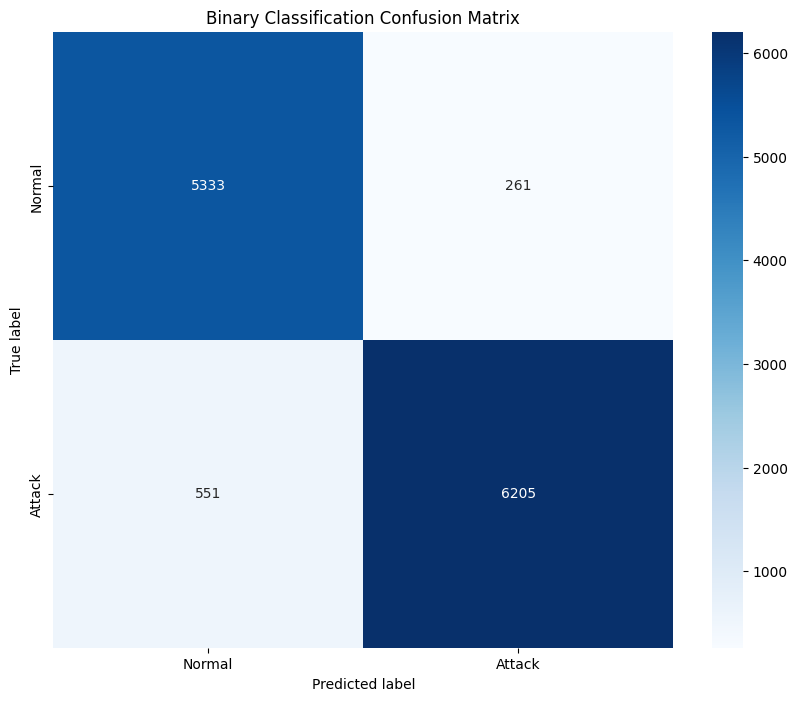

Binary Classification Feature Importances:
Feature Importances:
             feature  importance
5               sttl    0.249222
17  ct_dst_sport_ltm    0.094370
2             sbytes    0.088205
14             smean    0.084721
3             dbytes    0.069332
12            synack    0.063414
11            tcprtt    0.051946
7              sload    0.046603
18         state_INT    0.044156
16      ct_state_ttl    0.043630
4               rate    0.033772
0                dur    0.025768
15             dmean    0.023045
8              dload    0.021068
10            dinpkt    0.016385
9             sinpkt    0.014954
13            ackdat    0.011792
1              dpkts    0.009893
6               dttl    0.007723


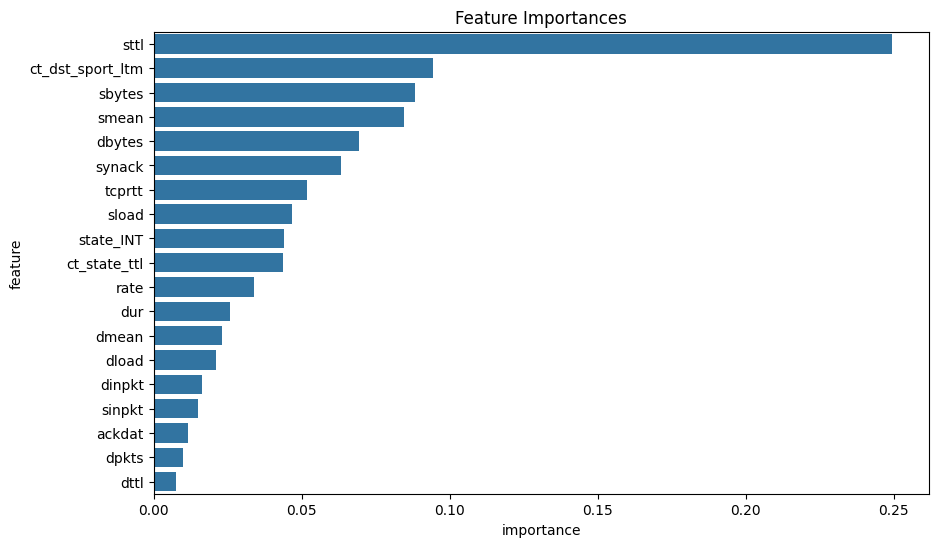


Multi-class Classification


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for multi-class model: {'svm__gamma': 'scale', 'svm__C': 10, 'rf__n_estimators': 300, 'rf__max_depth': 30, 'mlp__hidden_layer_sizes': (100, 50, 25), 'gb__n_estimators': 300, 'gb__max_depth': 5}
Multi-class Classification Results:
Validation Set:
                precision    recall  f1-score   support

      Analysis       0.04      0.02      0.02       112
      Backdoor       0.14      0.07      0.09        91
           DoS       0.39      0.37      0.38       594
      Exploits       0.65      0.73      0.69      1700
       Fuzzers       0.60      0.19      0.28       886
       Generic       0.99      0.97      0.98      2831
        Normal       0.86      0.98      0.92      5553
Reconnaissance       0.93      0.75      0.83       517
     Shellcode       0.33      0.07      0.11        59
         Worms       0.33      0.14      0.20         7

      accuracy                           0.83     12350
     macro avg       0.53      0.43      0.45     12350
  weight

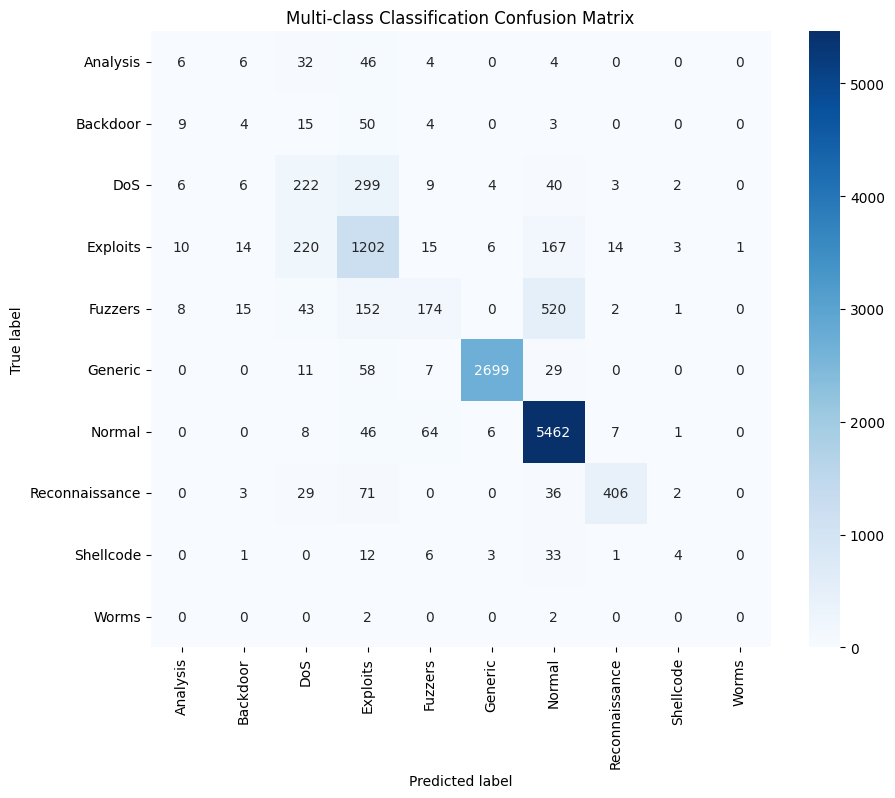

Multi-class Classification Feature Importances:
             feature  importance
2             sbytes    0.177106
14             smean    0.142472
17  ct_dst_sport_ltm    0.087401
0                dur    0.078060
7              sload    0.074071
4               rate    0.052757
9             sinpkt    0.052710
5               sttl    0.039590
3             dbytes    0.039304
12            synack    0.038570
8              dload    0.037666
15             dmean    0.034135
11            tcprtt    0.031923
13            ackdat    0.031474
10            dinpkt    0.031288
1              dpkts    0.019552
16      ct_state_ttl    0.015339
6               dttl    0.010459
18         state_INT    0.006124


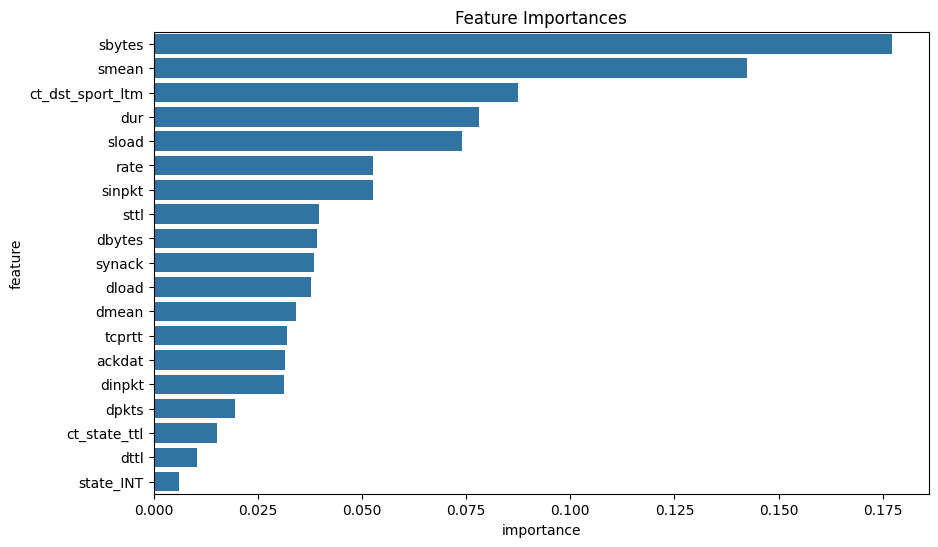


Analyzing Multi-class Misclassifications:
Sample of Misclassifications:
True: ['Fuzzers'], Predicted: ['Normal']
[ 0.34710351 -0.0652913  -0.04078221 -0.08196832 -0.55445589  0.71944006
  1.33959885 -0.35886795 -0.26256531 -0.08441571  0.11540217  1.98676811
  2.46855949  1.0092331  -0.27115838 -0.14012772 -0.34602656 -0.45018649
 -0.84215918]
---
True: ['Exploits'], Predicted: ['Fuzzers']
[-0.21372681 -0.15181641 -0.04596744 -0.08736871 -0.07389554  0.71944006
 -0.82039474 -0.19367612 -0.26349797 -0.12217885 -0.09416902 -0.48202491
 -0.41290971 -0.48407269 -0.41986026 -0.47537059  0.59102107 -0.45018649
  1.18742398]
---
True: ['DoS'], Predicted: ['Analysis']
[-0.21372745 -0.15181641 -0.04540814 -0.08736871  0.11835001  0.71944006
 -0.82039474  0.08590526 -0.26349797 -0.1221795  -0.09416902 -0.48202491
 -0.41290971 -0.48407269 -0.18961219 -0.47537059  0.59102107  0.05696861
  1.18742398]
---
True: ['Exploits'], Predicted: ['DoS']
[-0.21372808 -0.15181641 -0.04540814 -0.08736871  0.28

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model zip file created and download initiated.


In [21]:
if __name__ == "__main__":
    # Load datasets
    df = pd.read_csv('/content/drive/My Drive/UNSW_NB15_testing-set.csv')

    # Preprocess the data
    X_train, X_val, X_test, y_binary_train, y_binary_val, y_binary_test, \
    y_multi_train, y_multi_val, y_multi_test, le_binary, le_multiclass, selected_features, scaler = preprocess_data(df)

    print("Selected Features:", selected_features)

    # Binary Classification
    print("Binary Classification")
    binary_model = HybridRFGB(n_estimators=100)
    binary_model, y_pred_binary = train_evaluate_model(X_train, X_val, X_test,
                                                       y_binary_train, y_binary_val, y_binary_test,
                                                       binary_model, "Binary Classification")

    plot_confusion_matrix(y_binary_test, y_pred_binary, classes=['Normal', 'Attack'],
                          title='Binary Classification Confusion Matrix')

    # Analyze feature importances for binary classification
    print("Binary Classification Feature Importances:")
    analyze_feature_importances(binary_model, selected_features)

    # Multi-class Classification
    print("\nMulti-class Classification")

    # Apply SMOTE for multi-class problem
    smote = SMOTE(random_state=42)
    X_multi_train_resampled, y_multi_train_resampled = smote.fit_resample(X_train, y_multi_train)

    # Define and optimize the multi-class model
    multi_model = ImprovedHybridModel()
    param_distributions = {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [None, 10, 20, 30],
        'gb__n_estimators': [100, 200, 300],
        'gb__max_depth': [3, 5, 7],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 'auto'],
        'mlp__hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)]
    }

    random_search = RandomizedSearchCV(multi_model.ensemble, param_distributions, n_iter=5, cv=3, random_state=42, n_jobs=-1)


     # Use a subset of data for faster tuning
    subset_size = min(10000, len(X_multi_train_resampled))
    X_subset = X_multi_train_resampled[:subset_size]
    y_subset = y_multi_train_resampled[:subset_size]

    random_search.fit(X_subset, y_subset)

    print("Best parameters for multi-class model:", random_search.best_params_)
    best_multi_model = random_search.best_estimator_

    # Evaluate the multi-class model
    y_multi_val_pred = best_multi_model.predict(X_val)
    y_multi_test_pred = best_multi_model.predict(X_test)

    print("Multi-class Classification Results:")
    print("Validation Set:")
    print(classification_report(y_multi_val, y_multi_val_pred, target_names=le_multiclass.classes_))
    print("\nTest Set:")
    print(classification_report(y_multi_test, y_multi_test_pred, target_names=le_multiclass.classes_))

    plot_confusion_matrix(y_multi_test, y_multi_test_pred, classes=le_multiclass.classes_,
                          title='Multi-class Classification Confusion Matrix')

    # Analyze feature importances for multi-class classification
    print("Multi-class Classification Feature Importances:")
    if hasattr(best_multi_model, 'feature_importances_'):
        importances = best_multi_model.feature_importances_
    else:
        importances = best_multi_model.named_estimators_['rf'].feature_importances_
    analyze_feature_importances_custom(importances, selected_features)

    # Analyze misclassifications for multi-class
    print("\nAnalyzing Multi-class Misclassifications:")
    analyze_misclassifications(X_test, y_multi_test, y_multi_test_pred, le_multiclass)

    # Save the models
    save_hybrid_model(binary_model, selected_features, le_binary, scaler, "saved_model_binary")
    save_hybrid_model(best_multi_model, selected_features, le_multiclass, scaler, "saved_model_multiclass")

    print("Analysis and model saving completed.")

    # Create and download zip file of saved models
    try:
        from google.colab import files
        !zip -r best_models.zip /content/saved_model_binary /content/saved_model_multiclass
        files.download('best_models.zip')
        print("Model zip file created and download initiated.")
    except ImportError:
        print("Not running in Google Colab. Zip file creation and download skipped.")
        print("You can manually zip the 'saved_model_binary' and 'saved_model_multiclass' folders.")